In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

# save models to pickle
import pickle

In [2]:
path = 'kaggle_data/'
toxic_data = pd.read_csv(path + 'train.csv')
print('Number of rows and columns in the toxic data set:', toxic_data.shape)

Number of rows and columns in the toxic data set: (159571, 8)


In [3]:
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [4]:
# split toxic_data into train and test
train = toxic_data[:int(len(toxic_data)*0.7)]
test = toxic_data[int(len(toxic_data)*0.7):]

### Visualize variables

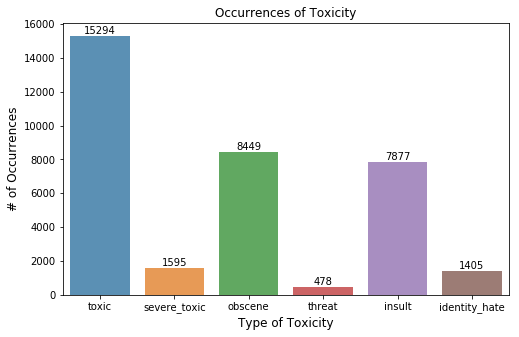

In [6]:
x = toxic_data.iloc[:, 2:].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('Occurrences of Toxicity')
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type of Toxicity', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

### Vectorizers

In [7]:
all_text = toxic_data['comment_text']

In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)

word_vectorizer.fit(all_text)

train_word_features = word_vectorizer.transform(train['comment_text'])
test_word_features = word_vectorizer.transform(test['comment_text'])

In [ ]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)

char_vectorizer.fit(all_text)

train_char_features = char_vectorizer.transform(train['comment_text'])
test_char_features = char_vectorizer.transform(test['comment_text'])

In [ ]:
# save vectorizers into pickle files
pickle.dump(word_vectorizer, open('models/word_vectorizer.pickle', 'wb'))
pickle.dump(char_vectorizer, open('models/char_vectorizer.pickle', 'wb'))

In [ ]:
train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

### Train & Score Models

In [ ]:
models = {}
scores = []

for col in target_columns:
    train_target = train[col]
    classifier = LogisticRegression(C = 20, class_weight = 'balanced')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for {} is {}'.format(col, cv_score))

    classifier.fit(train_features, train_target)
    print('Building model for column: {}'.format(col))
    models[col] = classifier
    
print('Total CV score is {}'.format(np.mean(scores)))

In [ ]:
# save Logistic Regression models into pickle files
for col in target_columns:
    filename = 'models/model_{}.sav'.format(col)
    pickle.dump(model[col], open(filename, 'wb'))